In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, 
    classification_report, precision_recall_curve
)
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import catboost as cb
import mlflow
import mlflow.lightgbm
import mlflow.catboost
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Setup MLflow (local file tracking for development)
project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
mlflow_uri = str(project_root / "mlruns")
mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment("churn-prediction-models")

<Experiment: artifact_location='/Users/anojanyogenthiran/Projects/churn-prediction/mlruns/452337064468531822', creation_time=1765256125687, experiment_id='452337064468531822', last_update_time=1765256125687, lifecycle_stage='active', name='churn-prediction-models', tags={}>

In [2]:
# Load data with features
data_features = "/Users/anojanyogenthiran/Projects/churn-prediction/data/features/data_with_features.csv"
df = pd.read_csv(data_features)

print(f"Dataset shape: {df.shape}")
print(f"Churn rate: {df['Churn'].mean():.3f}")
df.head()

Dataset shape: (7043, 33)
Churn rate: 0.265


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,charges_ratio,service_count,contract_payment,has_phone,has_internet,has_fiber,is_monthly_contract,is_electronic_check,is_senior,no_protection
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,0.967585,1,Month-to-month_Electronic check,0,1,0,1,1,0,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,0.030124,3,One year_Mailed check,1,1,0,0,0,0,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,0.493358,3,Month-to-month_Mailed check,1,1,0,1,0,0,0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,0.022967,3,One year_Bank transfer (automatic),0,1,0,0,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,0.463151,1,Month-to-month_Electronic check,1,1,1,1,1,0,1


In [3]:
# Separate target
y = df['Churn']
X = df.drop('Churn', axis=1)

# Identify categorical columns (need encoding for models)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

Categorical columns (18): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group', 'monthly_charges_bin', 'contract_payment']
Numerical columns (14): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'avg_monthly_charges', 'charges_ratio', 'service_count', 'has_phone', 'has_internet', 'has_fiber', 'is_monthly_contract', 'is_electronic_check', 'is_senior', 'no_protection']


In [4]:
# For LightGBM - Label encoding is sufficient
X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    
print(f"Final shape: {X_encoded.shape}")
X_encoded.head()

Final shape: (7043, 32)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,charges_ratio,service_count,contract_payment,has_phone,has_internet,has_fiber,is_monthly_contract,is_electronic_check,is_senior,no_protection
0,0,0,1,0,1,0,1,0,0,2,...,0.967585,1,2,0,1,0,1,1,0,0
1,1,0,0,0,34,1,0,0,2,0,...,0.030124,3,7,1,1,0,0,0,0,0
2,1,0,0,0,2,1,0,0,2,2,...,0.493358,3,3,1,1,0,1,0,0,0
3,1,0,0,0,45,0,1,0,2,0,...,0.022967,3,4,0,1,0,0,0,0,0
4,0,0,0,0,2,1,0,1,0,0,...,0.463151,1,2,1,1,1,1,1,0,1


In [5]:
# Split data
# First: train+val vs test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Second: train vs val (75/25 of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

print("Data split:")
print(f"  Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

print("\nChurn rates:")
print(f"  Train: {y_train.mean():.3f}")
print(f"  Val:   {y_val.mean():.3f}")
print(f"  Test:  {y_test.mean():.3f}")

Data split:
  Train: 4225 (60.0%)
  Val:   1409 (20.0%)
  Test:  1409 (20.0%)

Churn rates:
  Train: 0.265
  Val:   0.265
  Test:  0.265


In [6]:
def evaluate_model(y_true, y_pred, y_proba, dataset_name=""):
    """Evaluate model and print metrics."""
    
    print(f"\n{'='*50}")
    print(f"{dataset_name} Performance")
    print(f"{'='*50}")
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

def plot_roc_curve(y_true, y_proba, model_name=""):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name=""):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, top_n=20, model_name=""):
    """Plot feature importance."""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        importance = model.get_feature_importance()
    else:
        print("Model doesn't have feature importance")
        return
    
    # Create dataframe
    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feat_imp_df)), feat_imp_df['importance'])
    plt.yticks(range(len(feat_imp_df)), feat_imp_df['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return feat_imp_df

In [7]:
# Start MLflow run
with mlflow.start_run(run_name="lightgbm_baseline"):
    
    # Define model
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        num_leaves=31,
        random_state=42,
        verbose=-1,
        class_weight='balanced'  # Handle imbalance
    )
    
    # Log parameters
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("num_leaves", 31)
    mlflow.log_param("class_weight", "balanced")
    
    # Train
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
    )
    
    # Predictions
    y_train_pred = lgb_model.predict(X_train)
    y_train_proba = lgb_model.predict_proba(X_train)[:, 1]
    
    y_val_pred = lgb_model.predict(X_val)
    y_val_proba = lgb_model.predict_proba(X_val)[:, 1]
    
    # Evaluate
    train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "Training Set")
    val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "Validation Set")
    
    # Log metrics
    for metric, value in train_metrics.items():
        mlflow.log_metric(f"train_{metric}", value)
    
    for metric, value in val_metrics.items():
        mlflow.log_metric(f"val_{metric}", value)
    
    # Log model
    mlflow.lightgbm.log_model(lgb_model, "model")
    
    print(f"\n LightGBM baseline logged to MLflow")
    print(f"Run ID: {mlflow.active_run().info.run_id}")

2025/12/11 00:10:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Training Set Performance
Accuracy:  0.7709
Precision: 0.5442
Recall:    0.8394
F1 Score:  0.6604
ROC AUC:   0.8840

Confusion Matrix:
[[2316  788]
 [ 180  941]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      3104
           1       0.54      0.84      0.66      1121

    accuracy                           0.77      4225
   macro avg       0.74      0.79      0.74      4225
weighted avg       0.83      0.77      0.78      4225


Validation Set Performance
Accuracy:  0.7424
Precision: 0.5093
Recall:    0.8048
F1 Score:  0.6238
ROC AUC:   0.8432

Confusion Matrix:
[[745 290]
 [ 73 301]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.

2025/12/11 00:10:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



 LightGBM baseline logged to MLflow
Run ID: 53b65211a66c4441818e1a9de185c32b


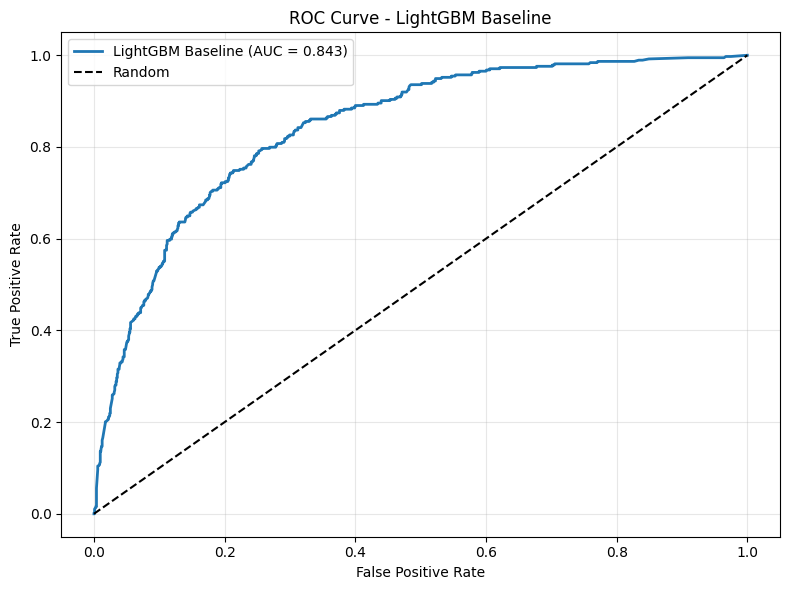

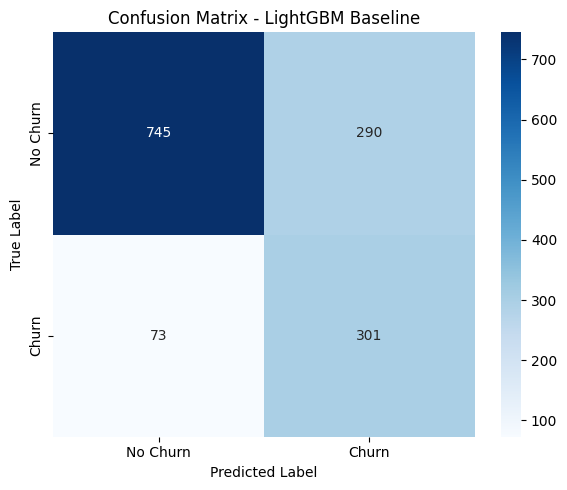

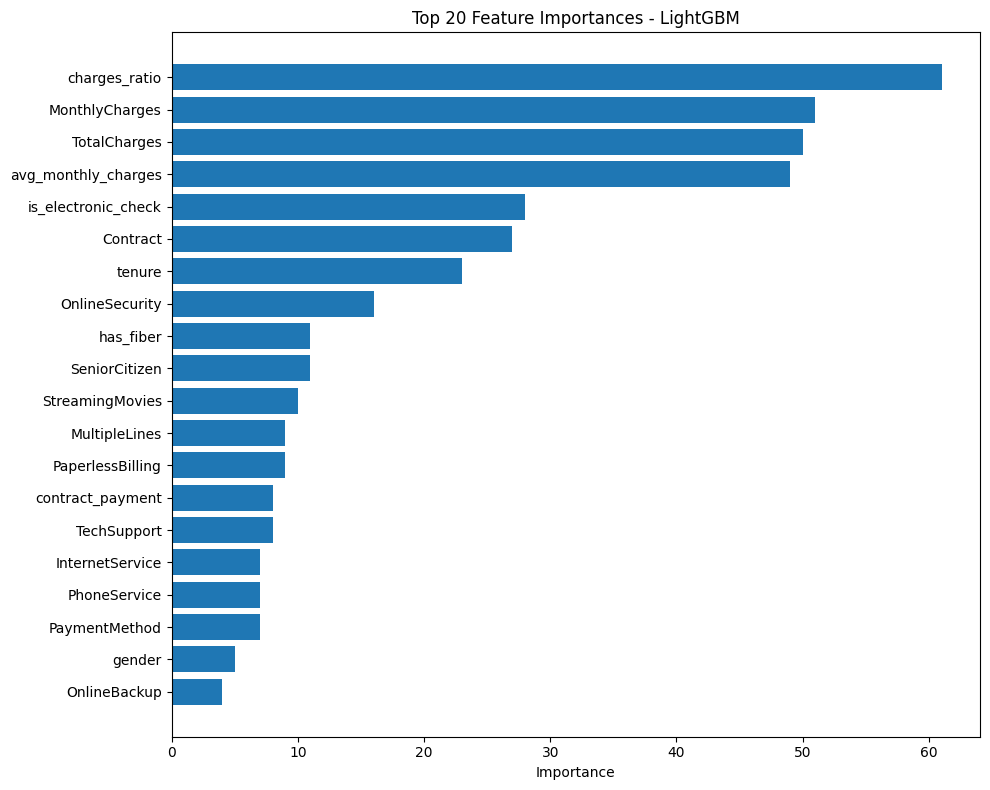

In [8]:
# ROC Curve
plot_roc_curve(y_val, y_val_proba, "LightGBM Baseline")

# Confusion Matrix
plot_confusion_matrix(y_val, y_val_pred, "LightGBM Baseline")

# Feature Importance
lgb_importance = plot_feature_importance(lgb_model, X_train.columns, top_n=20, model_name="LightGBM")

In [9]:
# Identify categorical features for CatBoost
cat_features_idx = [X_train.columns.get_loc(col) for col in categorical_cols]

# Start MLflow run
with mlflow.start_run(run_name="catboost_baseline"):
    
    # Define model
    cb_model = cb.CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=5,
        random_state=42,
        verbose=0,
        auto_class_weights='Balanced'  # Handle imbalance
    )
    
    # Log parameters
    mlflow.log_param("model_type", "CatBoost")
    mlflow.log_param("iterations", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("depth", 5)
    mlflow.log_param("auto_class_weights", "Balanced")
    
    # Train
    cb_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=10,
        verbose=False
    )
    
    # Predictions
    y_train_pred_cb = cb_model.predict(X_train)
    y_train_proba_cb = cb_model.predict_proba(X_train)[:, 1]
    
    y_val_pred_cb = cb_model.predict(X_val)
    y_val_proba_cb = cb_model.predict_proba(X_val)[:, 1]
    
    # Evaluate
    train_metrics_cb = evaluate_model(y_train, y_train_pred_cb, y_train_proba_cb, "Training Set")
    val_metrics_cb = evaluate_model(y_val, y_val_pred_cb, y_val_proba_cb, "Validation Set")
    
    # Log metrics
    for metric, value in train_metrics_cb.items():
        mlflow.log_metric(f"train_{metric}", value)
    
    for metric, value in val_metrics_cb.items():
        mlflow.log_metric(f"val_{metric}", value)
    
    # Log model
    mlflow.catboost.log_model(cb_model, "model")
    
    print(f"\n CatBoost baseline logged to MLflow")
    print(f"Run ID: {mlflow.active_run().info.run_id}")

2025/12/11 00:10:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Training Set Performance
Accuracy:  0.7605
Precision: 0.5308
Recall:    0.8385
F1 Score:  0.6501
ROC AUC:   0.8693

Confusion Matrix:
[[2273  831]
 [ 181  940]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      3104
           1       0.53      0.84      0.65      1121

    accuracy                           0.76      4225
   macro avg       0.73      0.79      0.73      4225
weighted avg       0.82      0.76      0.77      4225


Validation Set Performance
Accuracy:  0.7424
Precision: 0.5093
Recall:    0.8075
F1 Score:  0.6246
ROC AUC:   0.8390

Confusion Matrix:
[[744 291]
 [ 72 302]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.81      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.

2025/12/11 00:10:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



 CatBoost baseline logged to MLflow
Run ID: 0653644e1c324fa2af67b2b115f515df


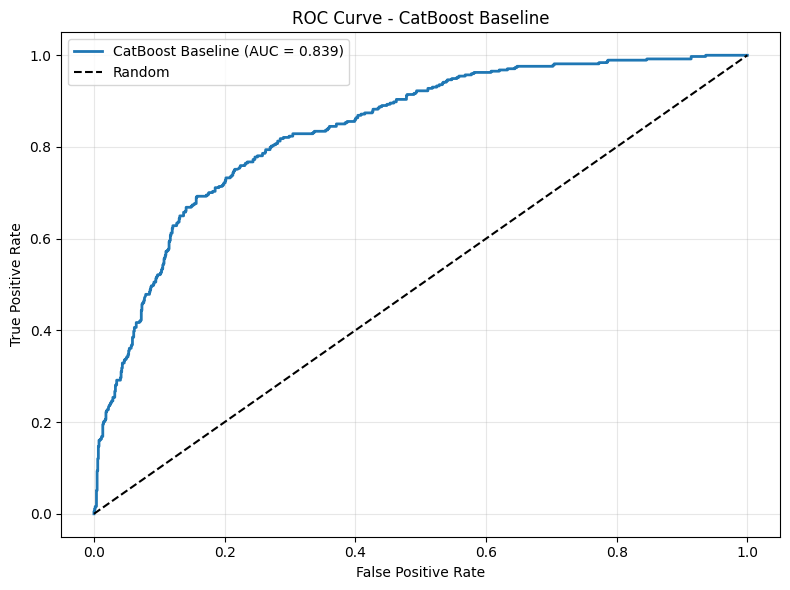

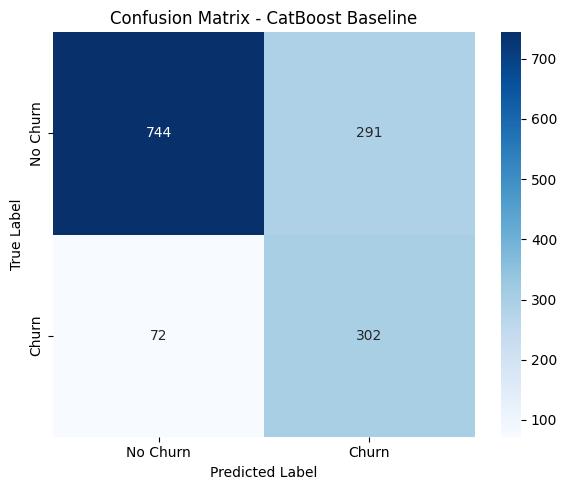

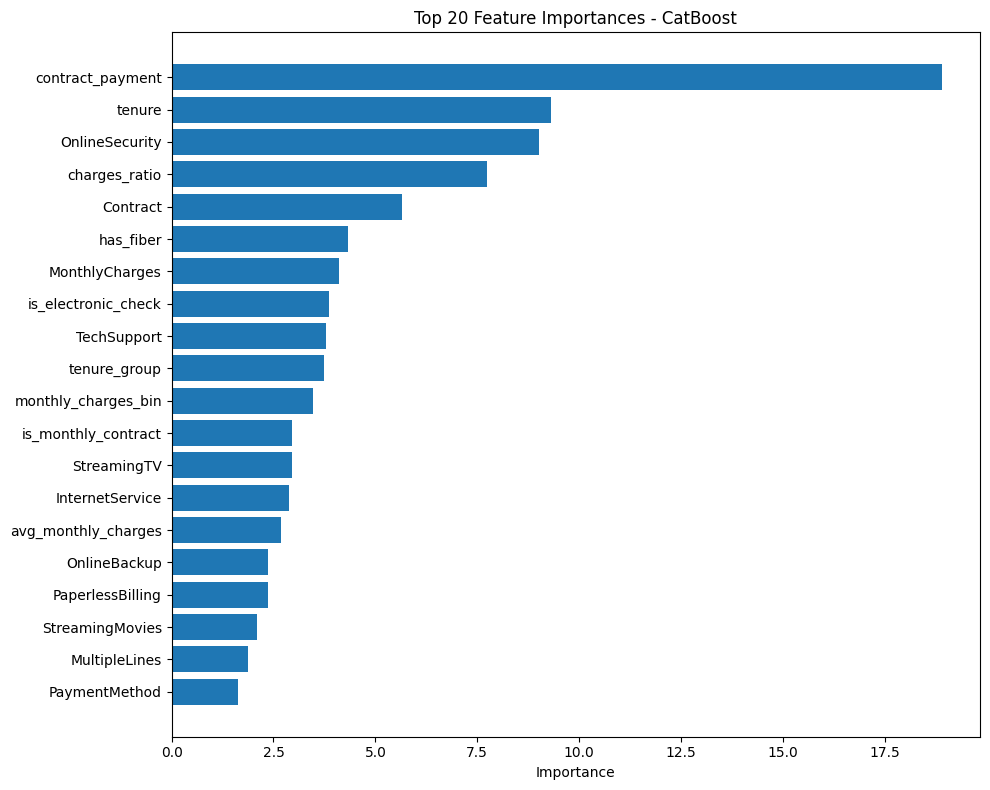

In [10]:
# ROC Curve
plot_roc_curve(y_val, y_val_proba_cb, "CatBoost Baseline")

# Confusion Matrix
plot_confusion_matrix(y_val, y_val_pred_cb, "CatBoost Baseline")

# Feature Importance
cb_importance = plot_feature_importance(cb_model, X_train.columns, top_n=20, model_name="CatBoost")

Model Comparison (Validation Set):
          accuracy  precision    recall        f1   roc_auc
LightGBM   0.74237   0.509306  0.804813  0.623834  0.843221
CatBoost   0.74237   0.509275  0.807487  0.624612  0.839012


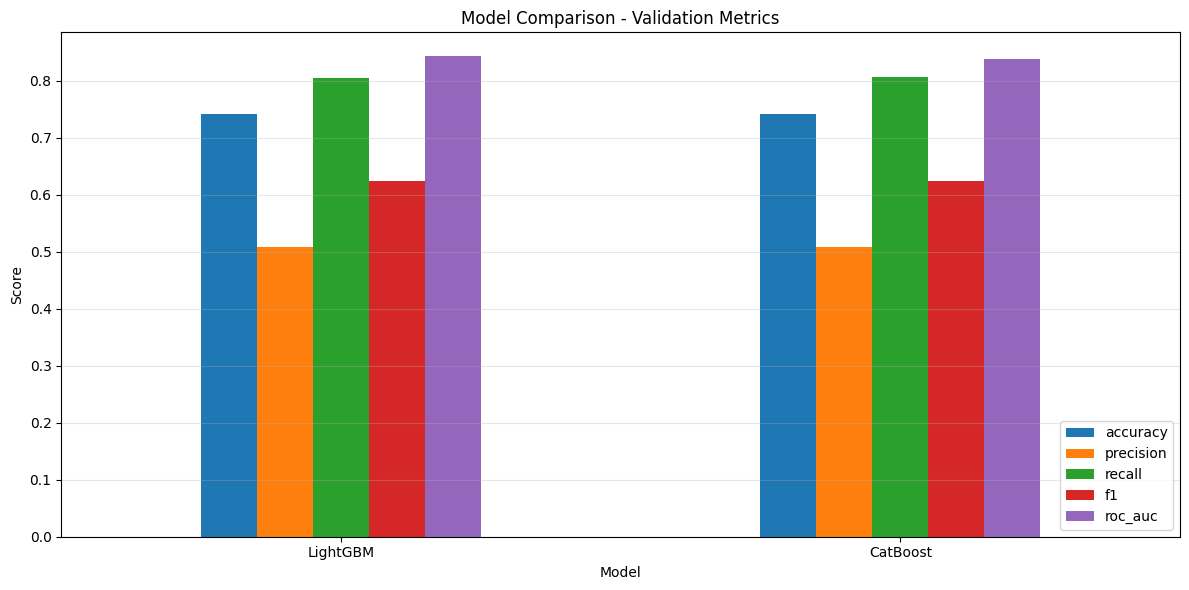

In [11]:
# Compare validation metrics
comparison_df = pd.DataFrame({
    'LightGBM': val_metrics,
    'CatBoost': val_metrics_cb
}).T

print("Model Comparison (Validation Set):")
print(comparison_df)

# Visualize comparison
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison - Validation Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Choose best model based on ROC AUC
if val_metrics['roc_auc'] > val_metrics_cb['roc_auc']:
    best_model = lgb_model
    best_model_name = "LightGBM"
    print(f"✅ Best model: LightGBM (ROC AUC: {val_metrics['roc_auc']:.4f})")
else:
    best_model = cb_model
    best_model_name = "CatBoost"
    print(f"✅ Best model: CatBoost (ROC AUC: {val_metrics_cb['roc_auc']:.4f})")

# Save model
import joblib

# Determine project root and models path
project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
model_path = project_root / "models"
model_path.mkdir(parents=True, exist_ok=True)

model_file = model_path / "best_model.pkl"
joblib.dump(best_model, model_file)
print(f"Saved best model to {model_file}")

# Save label encoders
encoders_file = model_path / "label_encoders.pkl"
joblib.dump(label_encoders, encoders_file)
print(f"Saved label encoders to {encoders_file}")

# Save feature names
feature_names_file = model_path / "feature_names.pkl"
joblib.dump(X_train.columns.tolist(), feature_names_file)
print(f"Saved feature names to {feature_names_file}")

✅ Best model: LightGBM (ROC AUC: 0.8432)
Saved best model to /Users/anojanyogenthiran/Projects/churn-prediction/models/best_model.pkl
Saved label encoders to /Users/anojanyogenthiran/Projects/churn-prediction/models/label_encoders.pkl
Saved feature names to /Users/anojanyogenthiran/Projects/churn-prediction/models/feature_names.pkl



Test Set Performance
Accuracy:  0.7431
Precision: 0.5104
Recall:    0.7888
F1 Score:  0.6197
ROC AUC:   0.8399

Confusion Matrix:
[[752 283]
 [ 79 295]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



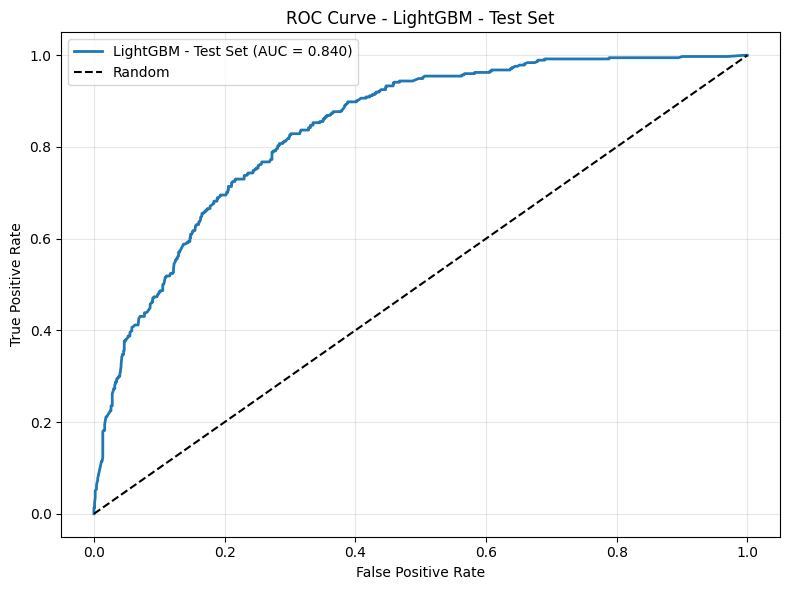

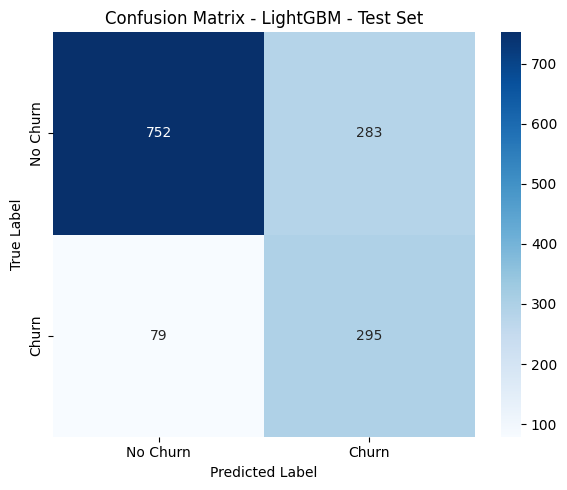


Final Test ROC AUC: 0.8399


In [13]:
# Predictions on test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "Test Set")

# Visualize
plot_roc_curve(y_test, y_test_proba, f"{best_model_name} - Test Set")
plot_confusion_matrix(y_test, y_test_pred, f"{best_model_name} - Test Set")

print(f"\nFinal Test ROC AUC: {test_metrics['roc_auc']:.4f}")